In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import trompy as tp

veh_color="black"
hist_color="red"

In [2]:
def get_event_codes(row):

    return {41: row.spout1, 42: row.spout2, 43: row.spout3, 44: row.spout4, 45: row.spout5}

# This is a function that reads in data from a csv file into a pandas dataframe (similar to an R dataframe)

def load_data(csv_file, event_codes, injection):

    lick_events = [41,42,43,44,45]
    
    df = pd.read_csv(csv_file, header=None, sep=r'\s+', names=["event", "timestamp"])
    date = ("-").join(csv_file.name.split("_")[:3])
    mouse = csv_file.name.split("_")[3].split(".")[0]
    
    df = df.assign(date=date, mouse=mouse).query("event in @lick_events")
    
    return (df
            .assign(
                    injection=injection,
                    event=lambda df: df.event.replace(event_codes)
                   )
            .reset_index()
            .loc[:, ["mouse", "date", "injection", "event", "timestamp"]]
           )

In [3]:

DATAFOLDER = Path("C:/Data/histamine_multispout/raw/")

FIGSFOLDER = Path("C:/Users/kvo019/OneDrive - UiT Office 365/Pipette 2/People/Linnea/Manuscripts/hislight paper/figures")

STATSFOLDER = Path("C:/Users/kvo019/OneDrive - UiT Office 365/Pipette 2/People/Linnea/Manuscripts/hislight paper")

metadata = pd.read_excel("C:/Data/histamine_multispout/metafile.xlsx")

allrows = []

for row in metadata.iterrows():
    #print(row)
    #print(get_event_codes(row))
    allrows.append(load_data(Path("C:/Data/histamine_multispout/raw/") / row[1].filename, get_event_codes(row[1]), row[1].injection))
    
df = pd.concat(allrows).reset_index()

In [4]:
metadata

,filename,mouse,date,injection,cohort,spout1,spout2,spout3,spout4,spout5
0,2023_12_05_jem01.csv,jem01,2023-12-05,his,2,suc20,suc30,suc05,suc10,suc00
1,2023_12_05_jem02.csv,jem02,2023-12-05,veh,1,suc30,suc10,suc20,suc00,suc05
2,2023_12_05_jem03.csv,jem03,2023-12-05,veh,2,suc20,suc30,suc05,suc10,suc00
3,2023_12_05_jem04.csv,jem04,2023-12-05,his,1,suc30,suc10,suc20,suc00,suc05
4,2023_12_05_jem05.csv,jem05,2023-12-05,veh,4,suc00,suc05,suc10,suc20,suc30
5,2023_12_05_jem06.csv,jem06,2023-12-05,his,3,suc20,suc30,suc05,suc10,suc00
6,2023_12_05_jem07.csv,jem07,2023-12-05,his,4,suc00,suc05,suc10,suc20,suc30
7,2023_12_05_jem08.csv,jem08,2023-12-05,veh,3,suc20,suc30,suc05,suc10,suc00
8,2023_12_06_jem01.csv,jem01,2023-12-06,veh,2,suc20,suc30,suc05,suc10,suc00
9,2023_12_06_jem02.csv,jem02,2023-12-06,his,1,suc30,suc10,suc20,suc00,suc05


In [5]:
# This function takes that big dataframe and adds up all the licks per concentration per day

def make_total_licks_df(df):

    return (df
            .groupby(['injection', 'mouse', 'event'])
            .agg({'timestamp': 'count'})
            .pivot_table(columns="event", values="timestamp", index=["mouse", "injection"])
            .reset_index()
            .fillna(0)
            .assign(total_licks=lambda df_: df_.loc[:,lick_cols].sum(axis=1))
    )

lick_cols = ["suc00", "suc05", "suc10", "suc20", "suc30"]
nlicks_df = make_total_licks_df(df)

In [6]:
nlicks_df



event,mouse,injection,suc00,suc05,suc10,suc20,suc30,total_licks
0,jem01,his,6.0,40.0,64.0,22.0,17.0,149.0
1,jem01,veh,20.0,58.0,120.0,126.0,259.0,583.0
2,jem02,his,5.0,10.0,5.0,52.0,187.0,259.0
3,jem02,veh,17.0,40.0,77.0,176.0,230.0,540.0
4,jem03,his,3.0,41.0,40.0,128.0,304.0,516.0
5,jem03,veh,30.0,249.0,204.0,199.0,228.0,910.0
6,jem04,his,24.0,21.0,23.0,98.0,174.0,340.0
7,jem04,veh,11.0,43.0,3.0,125.0,222.0,404.0
8,jem05,his,0.0,0.0,0.0,11.0,2.0,13.0
9,jem05,veh,22.0,54.0,51.0,212.0,275.0,614.0


In [7]:
# Save the DataFrame to a CSV file
csv_path = STATSFOLDER / "multispout_individual_licks_per_trial_data.csv"
nlicks_df.to_csv(csv_path, index=False)

print(f"CSV file saved at: {csv_path}")

CSV file saved at: C:\Users\kvo019\OneDrive - UiT Office 365\Pipette 2\People\Linnea\Manuscripts\hislight paper\multispout_individual_licks_per_trial_data.csv


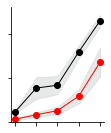

In [10]:
f, ax = plt.subplots(figsize=(2,2),
                    gridspec_kw={"wspace": 0.4,
                                 "left": 0.1,
                                 "right": 0.75,
                                 "top": 0.9,
                                 "bottom": 0.1}
                    )

tp.shadedError(ax, nlicks_df
                    .query("injection == 'veh'")
                    .loc[:,lick_cols]
                    .div(20), # for 20 trials of each concentration, gives licks per trial
               linecolor=veh_color)

tp.shadedError(ax, nlicks_df
                    .query("injection == 'his'")
                    .loc[:,lick_cols]
                    .div(20), # for 20 trials of each concentration, gives licks per trial
               linecolor=hist_color)

ax.plot(nlicks_df
         .query("injection == 'veh'")
         .loc[:,lick_cols]
         .mean()
         .div(20),
         linestyle="",
         marker="o",
         color=veh_color
        )

ax.plot(nlicks_df
         .query("injection == 'his'")
         .loc[:,lick_cols]
         .mean()
         .div(20),
         linestyle="",
         marker="o",
         color=hist_color
        )

#ax.set_ylabel("Licks per trial")
ax.set_ylim([0,13])
ax.set_yticks([0,5,10])
ax.set_yticklabels([])

#ax.set_xlabel("Sucrose concentration (%)")
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels([])

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

f.savefig(FIGSFOLDER / "multispout_licks_per_trial.pdf")



In [9]:

# Extract individual licks per trial for each mouse for 'veh' and 'his' injections
veh_data = nlicks_df.query("injection == 'veh'").loc[:, lick_cols].div(20)
his_data = nlicks_df.query("injection == 'his'").loc[:, lick_cols].div(20)

# Create a DataFrame with the individual mouse data
# Assuming lick_cols represent the different concentrations or conditions

# Add the 'mouse' identifier column from the original DataFrame
licks_data = pd.DataFrame({
    'Mouse': nlicks_df.query("injection == 'veh'").mouse,  # Assuming there's a 'mouse' column
    'Concentration': list(range(len(lick_cols))),  # Replace with the actual concentration if known
    'Vehicle': veh_data.values.flatten(),
    'Histamine': his_data.values.flatten()
})

# Save the DataFrame to a CSV file
csv_path = STATSFOLDER / "multispout_individual_licks_per_trial_data.csv"
licks_data.to_csv(csv_path, index=False)

print(f"CSV file saved at: {csv_path}")


ValueError: arrays must all be same length

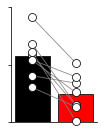

In [38]:
f, ax = plt.subplots(figsize=(1.5, 2),
                     gridspec_kw={"wspace": 0.4,
                                 "left": 0.1,
                                 "right": 0.9,
                                 "top": 0.9,
                                 "bottom": 0.1}
                                        )

tp.barscatter([nlicks_df.query("injection == 'veh'").total_licks.to_list(),
               nlicks_df.query("injection == 'his'").total_licks.to_list()],
              paired=True,
              barfacecolor_option="individual",
              barfacecolor=[veh_color, hist_color],
              ax=ax)

# ax.set_ylabel("Licks per trial")
ax.set_ylim([0,1000])
ax.set_yticks([0,500,1000])
ax.set_yticklabels([])

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

f.savefig(FIGSFOLDER / "multispout_total_licks.pdf")



In [27]:
[nlicks_df.query("injection == 'veh'").total_licks.to_list(),
               nlicks_df.query("injection == 'his'").total_licks.to_list()]

[[583.0, 540.0, 910.0, 404.0, 614.0, 303.0, 542.0, 683.0],
 [149.0, 259.0, 516.0, 340.0, 13.0, 134.0, 395.0, 153.0]]

In [28]:
nlicks_df["total_licks"] = nlicks_df.loc[:,lick_cols].sum(axis=1)

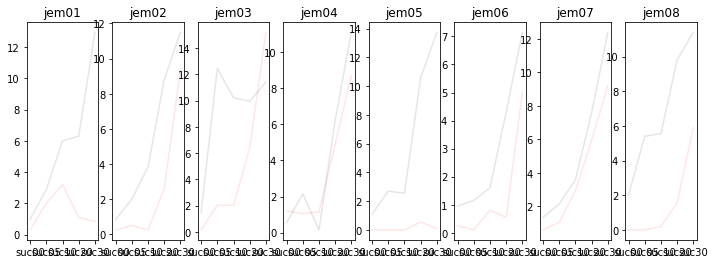

In [29]:
f, ax = plt.subplots(ncols=8, figsize=(12,4))

for axis, mouse in zip(ax, nlicks_df.mouse.unique()):
    axis.plot(nlicks_df.
              query("mouse == @mouse and injection == 'veh'").
              loc[:,lick_cols].div(20).T,
              color="black", alpha=0.1
    )
    
    axis.plot(nlicks_df.
                query("mouse == @mouse and injection == 'his'").
                loc[:,lick_cols].div(20).T,
                color="red", alpha=0.1
    )
    
    axis.set_title(mouse)
    


In [30]:
### making raster for poster

def get_trial_order(log_data_multi_file, mouse, day):
    df = pd.read_csv(log_data_multi_file)
    
    trials = (
             df
            .query("subject == @mouse and day == @day")
            .block_set
            .item()[1:-2]
            )

    return [int(x) for x in trials.split(",")]

def get_licks_by_trial(events_df):
    
    events = np.array(events_df.event.to_list())
    ts = events_df.timestamp.to_list()

    trials = []
    start_indices = np.where(events == 2)[0]

    for trial, idx in enumerate(start_indices):
        try:
            licks = ts[idx+1 : start_indices[trial+1]]
            trials.append([x - ts[idx] for x in licks])
        except IndexError:
            licks = ts[idx+1 :]
            trials.append([x - ts[idx] for x in licks])
            
    return trials

# for each file output a list of lists concentration > trials
def load_events(csv_file):
    
    df = pd.read_csv(csv_file, header=None, sep=r'\s+', names=["event", "timestamp"])
    
    df = df.query("event in @lick_and_session_events")
    
    return (df
#             .assign(

#                     event=lambda df: df.event.replace(event_codes[date])
#                    )
#             .reset_index()
# #             .loc[:, ["mouse", "date", "box", "event", "timestamp"]]
           )

lick_and_session_events = [2,41,42,43,44,45]
event_codes = {}
event_codes["2023-10-24"] = {41: "suc20", 42: "suc30", 43: "suc05", 44: "suc10", 45: "suc00"}

file = Path('D:/TestData/headfixed_behavior/2023_10_24_jem01.csv')
df = load_events(file)

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\TestData\\headfixed_behavior\\2023_10_24_jem01.csv'

In [31]:
def get_data_for_raster(filename, mouse, day):
    datafile = Path("C:/Users/jmc010/Dropbox/multispout_jem/jem_20240429/log_data_multi.csv")
    trial_order = get_trial_order(datafile, MOUSE, DAY)

    file = Path(f'../../data/raw/{FILENAME}')
    df = load_events(file)

    licks_per_trial = {}
    for trial_type, trial_licks in zip(trial_order, get_licks_by_trial(df)):
        if licks_per_trial.get(trial_type) is None:
            licks_per_trial[trial_type] = []
            licks_per_trial[trial_type].append(trial_licks)
        else:
            licks_per_trial[trial_type].append(trial_licks)
            
    licks_per_trial_by_conc = {}
    for idx, spout in enumerate(metadata.query("filename == @FILENAME").loc[:,"spout1":"spout5"].items()):
        conc = spout[1].values[0]
        licks_per_trial_by_conc[conc] = licks_per_trial[idx]
        
    return licks_per_trial_by_conc

## For jem02
# vehicle
FILENAME = '2023_12_05_jem02.csv'
MOUSE = 'jem02'
DAY = 'd23'

raster_data_veh = get_data_for_raster(FILENAME, MOUSE, DAY)

# histidine
FILENAME = '2023_12_06_jem02.csv'
MOUSE = 'jem02'
DAY = 'd24'

raster_data_his = get_data_for_raster(FILENAME, MOUSE, DAY)


# ## For jem06
# # vehicle
# FILENAME = '2023_12_06_jem06.csv'
# MOUSE = 'jem06'
# DAY = 'd24'

# raster_data_veh = get_data_for_raster(FILENAME, MOUSE, DAY)

# # histidine
# FILENAME = '2023_12_05_jem06.csv'
# MOUSE = 'jem06'
# DAY = 'd23'

# raster_data_his = get_data_for_raster(FILENAME, MOUSE, DAY)


# ## For jem08
# # vehicle
# FILENAME = '2023_12_06_jem08.csv'
# MOUSE = 'jem08'
# DAY = 'd24'

# raster_data_veh = get_data_for_raster(FILENAME, MOUSE, DAY)

# # histidine
# FILENAME = '2023_12_05_jem08.csv'
# MOUSE = 'jem08'
# DAY = 'd23'

# raster_data_his = get_data_for_raster(FILENAME, MOUSE, DAY)



FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\jmc010\\Dropbox\\multispout_jem\\jem_20240429\\log_data_multi.csv'

suc30


NameError: name 'raster_data_veh' is not defined

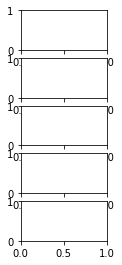

In [32]:
def plot_raster(licks_per_trial, trial_type, color="red", ax=None):
    
    if ax == None:
        f, ax = plt.subplots(figsize=(1.5,4))

    licks = licks_per_trial[trial_type]
    for y, trial in enumerate(licks):
        ax.vlines(trial, y, y+1, color=color)
        
    ax.set_ylim([0, 20])
        
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

f, ax = plt.subplots(nrows = 5,
                     figsize=(1.5,4),
                     gridspec_kw={"wspace": 0.4,
                                 "left": 0.1,
                                 "right": 0.9,
                                 "top": 0.9,
                                 "bottom": 0.1}
                     )

conc_order = ["suc00", "suc05", "suc10", "suc20", "suc30"]

def rgb(rgb):
    return [c / 255.0 for c in rgb]

colors = [rgb([245, 213, 68]),
          rgb([237, 108, 36]),
          rgb([168, 45, 96]),
          rgb([77, 36, 104]),
          "k"]

colors = ["k"]*5

for conc, axis, color in zip(conc_order[::-1], ax, colors):
    print(conc)
    plot_raster(raster_data_veh, conc, ax=axis, color=color)
    
f.savefig(FIGSFOLDER  / "multispout_raster_vehicle.pdf")

suc30


NameError: name 'raster_data_his' is not defined

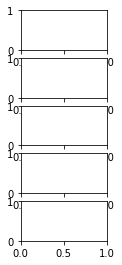

In [33]:
f, ax = plt.subplots(nrows = 5,
                     figsize=(1.5,4),
                     gridspec_kw={"wspace": 0.4,
                                 "left": 0.1,
                                 "right": 0.9,
                                 "top": 0.9,
                                 "bottom": 0.1}
                     )

conc_order = ["suc00", "suc05", "suc10", "suc20", "suc30"]

def rgb(rgb):
    return [c / 255.0 for c in rgb]

colors = [rgb([245, 213, 68]),
          rgb([237, 108, 36]),
          rgb([168, 45, 96]),
          rgb([77, 36, 104]),
          "k"]

colors = ["red"]*5

for conc, axis, color in zip(conc_order[::-1], ax, colors):
    print(conc)
    plot_raster(raster_data_his, conc, ax=axis, color=color)
    
f.savefig(FIGSFOLDER  / "multispout_raster_histidine.pdf")